In [1]:
# 1 ns unit for time

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.special import erf

pi = np.pi
exp = np.exp
sqrt = np.sqrt
hbar = 1.0546e-34*1e-9  # reduced Planck constant
options = Options()

In [2]:
Nq = 2  # number of levels in qubit

wq = 7*2*pi  # qubit frequency
wp = wq        # pump frequency

kq = 50e-6*2*pi  # photon emission frequency of qubit (qubit decay rate)

Ec = 0.2*2*pi  # Anharmonicity

t0 = 0            # start Gaussian pulse Omega
t1 = t0 + 50   # end Gaussian pulse Omega
t2 = t1 + 10   # start square pulse at resonator 1
t3 = t2 + 300  # end square pulse at resonator 1
t4 = t3 + 10   # start square pulse at resonator 2
t5 = t4 + 300  # end square pulse at resonator 2
t6 = t5 + 0#10   # t0
tg = 10        # Gaussian rise and fall time of square pulse

N_repeat = 3  # number of times to repeat cycle
Np = 1000     # number of discrete time steps per cycle for which to store the output
Q = 3  # number of std's in Gaussian curves, rises and falls

In [3]:
# Qubit operators
b = destroy(Nq)
nq = b.dag()*b
sx = sigmax() # x-projection of qubit level
sy = sigmay() # y-projection of qubit level
sz = sigmaz() # z-projection of qubit level

# Jaynes-Cummings Hamiltonian
Hjc = - Ec/2*b.dag()*b.dag()*b*b

# Hamiltonian arguments
H_args = {"t0" : t0, "t1" : t1, "t2" : t2, "t3" : t3, 
          "t4" : t4, "t5" : t5, "t6" : t6, "tg" : tg,
          "Q"  : Q,  "N"  : N_repeat, "Np" : Np}

In [4]:
def pump_strength(args):
    t0 = args['t0']
    t1 = args['t1']
    Q  = args['Q']
    tau = t1-t0      # pulse duration
    std = tau/(2*Q)  # standard deviation
    time = lambda t : t/(std*sqrt(2))  # t' to pass to error function
    
    """
    TODO: include qubit decay rate kq
    """
    
    integral = sqrt(2*pi)*std*erf(time(tau)/2)
    Omega = pi/integral
    return Omega

# Pump Hamiltonian
Omega = pump_strength(H_args)
H_args['Omega'] = Omega
Hp = Omega/2*(b + b.dag())  # including rotating frame approximation

In [5]:
# Collapse operators, losses
cq = sqrt(kq)*b   # qubit
c_ops = [cq]

# Expectation operators
e_ops = [nq, sx, sy, sz]

In [6]:
def pump(t, args):
    t0 = args['t0']  # start of pulse
    t1 = args['t1']  # end of pulse
    t6 = args['t6']  # length of cycle
    Q  = args['Q']
    
    t = t%t6  # repeat cycle
    mu = (t1-t0)/2  # pulse center in time domain
    std = (t1-t0)/(2*Q)  # standard deviation
    confine = np.heaviside((t-t0), 0) - np.heaviside((t-t1), 0)  # entire pulse
    
    pulse = exp(-(t-mu)**2/(2*std**2))*confine
    return pulse

In [28]:
H = [Hjc, [Hp, pump]]  # complete Hamiltonian
tlist = np.linspace(0, N_repeat*t6, N_repeat*Np)  # discrete time steps for which to store the output
psi0 = basis(Nq,0)  # initial state

options.method = 'bdf'
options.rtol = 1e-9
options.store_states=True

result = mesolve(H, psi0, tlist, c_ops, e_ops=e_ops, args=H_args, options=options)

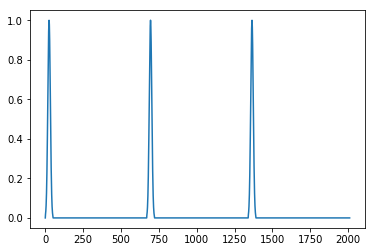

In [29]:
pulse = pump(tlist, H_args)
plt.plot(tlist, pulse)

Text(0,0.5,'$n_q$')

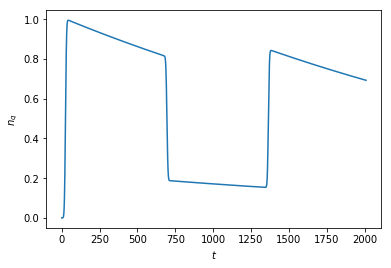

In [30]:
plt.plot(tlist, result.expect[0])
plt.xlabel("$t$")
plt.ylabel("$n_q$")